In [1]:
import os
import numpy as np
import scipy as sp
import scipy.io
from scipy.linalg import expm
import pandas as pandas
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from Nexis_functions import heatmap, total_tau_plot, normalize_by_l2_norm, mse_matrix

## Nexis

In [2]:
class loading_matfiles:
    def __init__(self,datadir_=''):
        if (datadir_==''):
            curdir = os.getcwd()
            subdir = 'raw_data_mouse'
            datadir_ = os.path.join(curdir,subdir)
        self.datadir = datadir_ # Directory to load dependences from
    
    def load_file(self,datafile):
        datafile = os.path.join(self.datadir,datafile)
        datamat = scipy.io.loadmat(datafile)
        return datamat

class run_Nexis:
    def __init__(self,C_,U_,init_vec_,t_vec_,w_dir_=0,volcorrect_=0,use_baseline_=0,region_volumes_=[], logistic_term_=0, datadir_=''):
        self.C = C_ # Connectivity matrix, nROI x nROI
        self.U = U_ # Matrix or vector of cell type or gene expression, nROI x nTypes
        self.init_vec = init_vec_ # Binary vector indicating seed location OR array of baseline pathology values, nROI x 1
        self.t_vec = t_vec_ # Vector of time points to output model predictions, 1 x nt
        self.volcorrect = volcorrect_ # Binary flag indicating whether to use volume correction - ask ben 
        self.w_dir = w_dir_ # Binary flag indicating whether to use directionality or not 
        self.use_baseline = use_baseline_ # Binary flag indicating whether you are using baseline or a binary seed to initialize the model
        self.region_volumes = region_volumes_ # Array of region volumes, nROI x 1 if applicable 
        self.logistic_term = logistic_term_ #ADDED BY ROBIN
        
        if (datadir_==''):
            curdir = os.getcwd()
            subdir = 'raw_data_mouse'
            datadir_ = os.path.join(curdir,subdir)
        self.datadir = datadir_ # Directory to load dependences from

    def simulate_nexis(self, parameters):
        """
        Returns a matrix, Y, that is nROI x nt representing the modeled Nexis pathology
        given the provided parameters. alpha, beta, and gamma should be nonnegative scalars;
        s should be bounded between 0 and 1; b and p should be nCT-long vectors
        """
        # Define parameters
        ntypes = np.size(self.U,axis=1)
        alpha = parameters[0] # global connectome-independent growth (range [0,5])
        beta = parameters[1] # global diffusivity rate (range [0,5])
        if self.use_baseline:
            gamma = 1
        else:
            gamma = parameters[2] # seed rescale value (range [0,10])
        if self.w_dir==0:
            s = 0.5
        else:
            s = parameters[3] # directionality (0 = anterograde, 1 = retrograde)
        b = np.transpose(parameters[4:(ntypes+4)]) # cell-type-dependent spread modifier (range [-5,5])
        p = np.transpose(parameters[(ntypes+4):6]) # cell-type-dependent growth modifier (range [-5,5]) #EDITED
        k = parameters[6] # Carrying capacity ADDED
        
        # Define starting pathology x0
        x0 = gamma * self.init_vec
        
        # Define diagonal matrix Gamma containing spread-independent terms
        s_p = np.dot(self.U,p)
        Gamma = np.diag(s_p) + (alpha * np.eye(len(s_p))) 

        # Define Laplacian matrix L
        C_dir = (1-s) * np.transpose(self.C) + s * self.C
        coldegree = np.sum(C_dir,axis=0)
        L_raw = np.diag(coldegree) - C_dir
        s_b = np.dot(self.U,b)
        s_b = np.reshape(s_b,[len(s_b),1])
        S_b = np.tile(s_b,len(s_b)) + np.ones([len(s_b),len(s_b)])
        L = np.multiply(L_raw,np.transpose(S_b))

        # Apply volume correction if applicable
        if self.volcorrect:
            voxels_2hem = self.region_volumes

            # ROBIN'S EDIT
            inv_voxels_2hem = np.diag(np.squeeze(voxels_2hem).astype(float) ** (-1))
            
            #ORIGINAL
            #inv_voxels_2hem = np.diag(np.squeeze(voxels_2hem) ** (-1))
            
            L = np.mean(voxels_2hem) * np.dot(inv_voxels_2hem,L)

        # Define system dydt = Ax
        A = Gamma - (beta * L)

        # Solve 
        if self.logistic_term:
            y = self.sim_logistic(self.t_vec,x0,A,Gamma,k) 
        else:
            y = self.forward_sim(A,self.t_vec,x0)

        return y
    
    # Solve via analytic method (no logistic term)
    def forward_sim(self,A_,t_,x0_):
        y_ = np.zeros([np.shape(A_)[0],len(t_)])
        for i in list(range(len(t_))):
            ti = t_[i]
            y_[:,i] = np.dot(expm(A_*ti),np.squeeze(x0_)) 
        return y_
    
    # Solve via odeint with logistic term
    def sim_logistic(self,t_,x0_,A_,Gamma_,k_):

        # Define ODE function with a logistic term
        def ode_func(y, t, A, Gamma, k):
            dydt = np.dot(A, y) - np.dot(Gamma,np.square(y)) / k
            return dydt

        # Initial condition
        y0 = x0_

        # Solve ODE using odeint
        sol = odeint(ode_func, y0, t_, args=(A_,Gamma_,k_))

        # Transpose so that sol is an array with dim nROI x time points
        sol = sol.T

        return sol

## Preparing Inputs

In [3]:
# Prepare connectivity matrix

# Load connectivity matrix
connectivity_df = pandas.read_csv('Connectivity matrix.csv')

# List of striatal regions to exclude from further analysis due to errors in tau-PET imaging (CAN EDIT THIS)
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']

# Find indices (in the region order of the connectivity matrix) for regions to exclude 
excluded_indices = [connectivity_df.columns.get_loc(region) for region in regions_to_exclude]

# Define total number of subcortical regions and cortical regions per hemisphere
total_sub = 9 - len(regions_to_exclude)/2
total_cor = 34

# Delete striatal regions 
connectivity_df = connectivity_df.drop(index = excluded_indices)
connectivity_df = connectivity_df.drop(columns=regions_to_exclude)

# Convert connectivity matrix to a nROI x nROI array
connectivity_matrix = connectivity_df.values

# Normalize connectivity matrix (divide by max because min is already 0 in diagonal entries)
max = np.max(connectivity_matrix)
connectivity_matrix = connectivity_matrix / max

In [4]:
# Define the number of regions  
nROI = 86 - len(regions_to_exclude)


In [5]:
# Initial vector

# SET INITIAL VECTOR METHOD ('baseline' or 'binary')
init_vec_method = 'baseline' 

# OPTION 1: Use baseline data from EBM tau time series
if init_vec_method == 'baseline':

    init_con = pandas.read_csv('Regional tau time series - cerbellum normalized.csv')

    # Housekeeping
    init_con = init_con.drop('Unnamed: 0',axis=1)

    # Reorder regions to match region order of connectivity matrix
    new_order = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]
    init_con_reordered = init_con.iloc[:, new_order]

    # Delete striatal regions 
    columns_to_delete = init_con_reordered.columns[excluded_indices]
    init_con_excluded = init_con_reordered.drop(columns_to_delete, axis = 1)

    # Take the first row (time point 0) as initial vector
    init_vec = init_con_excluded.iloc[0].values

    # Set use_baseline NEXIS input to 1 to indicate use of baseline data as initial vector  
    use_baseline_ = 1 

#OPTION 2: Binary vector indicating seeding location 
if init_vec_method == 'binary':

    # lh-entorhinal: 14 if excluding striatal regions (22 if not)
    # rh-entorhinal: 48 if excluding striatal regions (56 if not)

    # Create a 1D array of zeros with length nROI
    array_length = nROI
    init_vec = np.zeros(array_length)

    # Set entries for seeding location to 1 
    init_vec[14] = 1 
    init_vec[48] = 1

    # Set use_baseline NEXIS input to 0 to indicate use of binary initial vector 
    use_baseline_ = 0 

In [6]:
# Load DK regional volumes 
regional_volumes = pandas.read_csv('DK_ROI_volumes.csv')

# Convert to an 1 x nROI array 
regional_volumes = regional_volumes.values

# Reorder to match that of connectivity matrix
new_order = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67]
regional_volumes_reordered = regional_volumes[new_order, :]

# Delete striatal regions
regional_volumes_excluded = np.delete(regional_volumes_reordered,excluded_indices)

In [7]:
# Define inputs to NEXIS

C_ = connectivity_matrix  # Connectivity matrix (nROI x nROI)
U_ = np.zeros((nROI, 1))  # Don't care about cell types (nROI x nTypes), set to nROI x 1 array of random numbers or 0
init_vec_ = init_vec # Initial tau vector (nROI x 1)
t_vec_ = np.linspace(0, 10, 100)  # Time vector (include 100 time points) (1 x nt)
w_dir_ = 0  # Since I don't care about directionality, set to 0 which overwrites s as 0.5
volcorrect_ = 1  # Binary flag set to 0 if not correcting for volume, set to 1 if correcting for volume and add regional volume data to regional_volumes
region_volumes_ = regional_volumes_excluded  # Regional volumes for normalization (nROI x 1)
degreecorrect_ = 0 # Binary flag indicating whether to normalize by degree (for Ashish, normally set this to 0)
logistic_term_ = 1 # Binary flag set to 1 to run with logistic term and 0 to run without
datadir_ = "../NDM output/NDM_output.csv"  # Data directory for output

In [15]:
print(type(init_vec_))

<class 'numpy.ndarray'>


## Load EBM Data

In [8]:
# Load tau time series from EBM (E(t)) to compare with NDM output (Y)

EBM_data = pandas.read_csv('Regional tau time series - cerbellum normalized.csv')

# Housekeeping
EBM_data = EBM_data.drop('Unnamed: 0',axis=1)

# Convert to an nROI x 100 array and transpose
EBM_data_array = EBM_data.values
EBM_data_transposed = EBM_data_array.T

# Reorder regions to match region order in NDM output
new_order = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]
EBM_data_reordered = EBM_data_transposed[new_order, :]

# Delete striatal regions 
EBM_data_excluded = np.delete(EBM_data_reordered, excluded_indices,axis = 0)

# Normalize by L2 norm
normalized_EBM_data_excluded = normalize_by_l2_norm(EBM_data_excluded)

## Parameter Optimization

In [9]:
#Optimize parameters by minimizing MSE between EBM data and Y

# Define a function that runs Nexis and calculates the MSE of Y and E(t) based on parameters alpha and beta (and gamma if using baseline seeding)
def Nexis_MSE(params):
    
    param1, param2, param3, param4, param5, param6, param7 = params 
    # param1 = alpha, param2 = beta, param3 = gamma, param4 = s, param5 = b, param6 = p, param7 =k
    
   # Initialize run_Nexis class 
    nexis_model_mse = run_Nexis(C_=C_, U_=U_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                        region_volumes_=region_volumes_, degreecorrect_=degreecorrect_, logistic_term_ = logistic_term_, datadir_=datadir_)

    # Parameters for simulate_nexis method
    parameters = [param1, param2, param3, param4, param5, param6, param7]  # [alpha, beta, gamma, s, b, p , k] 

    # Call the simulate_nexis method with the parameters
    Y = nexis_model_mse.simulate_nexis(parameters)

    error = mse_matrix(EBM_data_excluded, Y)
    
    return error

# Initial guesses for parameters (alpha, beta, gamma, s, b, p, k) # ADJUST THESE
init_guess = np.array([0.04, 1.01, 1, 0.5, 0, 0.07, 20])

# Bounds for each parameter [(min alpha, max alpha), (min beta, max beta), (min gamma, max gamma), etc. # ADJUST THESE
bounds = [(0, 2),(0, 5),(0,3),(0.5,0.5),(0,0),(0,1),(0,50)]

# Perform the optimization
result = minimize(Nexis_MSE, init_guess, bounds=bounds, method='L-BFGS-B', 
                  options={'ftol': 1e-6, 'gtol': 1e-6})

# Check the results
if result.success:
    optimized_params = result.x
    optimized_params = optimized_params.tolist( )
    print(f"Optimization successful. Optimized parameters (alpha, beta, gamma, s, b, p, k): {optimized_params}")
else:
    print("Optimization failed.", result.message)

Optimization successful. Optimized parameters (alpha, beta, gamma, s, b, p, k): [0.26578466302222054, 0.4901505014988503, 1.0, 0.5, 0.0, 0.07, 20.000567683872493]


## Running Nexis

[[ 0.00147594  0.00195084  0.00242528 ...  0.21392711  0.22094803
   0.22818535]
 [ 0.21062783  0.20883812  0.20715621 ...  0.99293414  1.01834701
   1.04438569]
 [ 0.21858387  0.21964649  0.22086287 ...  1.16081646  1.18742
   1.21465583]
 ...
 [ 0.09774004  0.10255251  0.107339   ...  1.14856423  1.17553425
   1.2031405 ]
 [-0.01291369 -0.00181678  0.00844968 ...  1.07931383  1.10646299
   1.13425476]
 [ 0.0944597   0.09532132  0.09640821 ...  1.06134442  1.08817371
   1.11564623]]


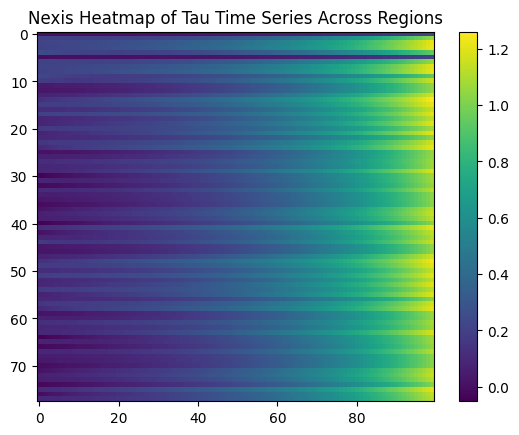

In [10]:
# Initialize run_Nexis class 
nexis_model = run_Nexis(C_=C_, U_=U_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                        region_volumes_=region_volumes_, degreecorrect_=degreecorrect_, logistic_term_=logistic_term_, datadir_=datadir_)

# Parameters for simulate_nexis method
parameters = optimized_params  # [alpha, beta, gamma, s, b, p, k] # CAN MANUALLY SET PARAMETERS HERE

# alpha = global coupling constant 
# beta = diffusivity constant (0-5)
# gamma = seed rescale value that fits binary initial vector to the same scale as empirical data from EBM
# s = directionality constant (if no directionaility, set to 0.5)
# b, p only relevent to cell type analysis

# Call the simulate_nexis method with the parameters
Y = nexis_model.simulate_nexis(parameters)

# Normalize by L2 norm
normalized_Y = normalize_by_l2_norm(Y)

# Print resulting matrix (nROI x # of time points)
print(Y)

# Plot heatmap of Y
plt = heatmap(init_vec_method, Y)

## Check Results

In [11]:
# Calculate MSE between E(t) and Y
mse = mse_matrix(normalized_EBM_data_excluded, normalized_Y)
print('Mean squared error: ' + str(mse))

Mean squared error: 0.0011444416171823072


<function matplotlib.pyplot.show(close=None, block=None)>

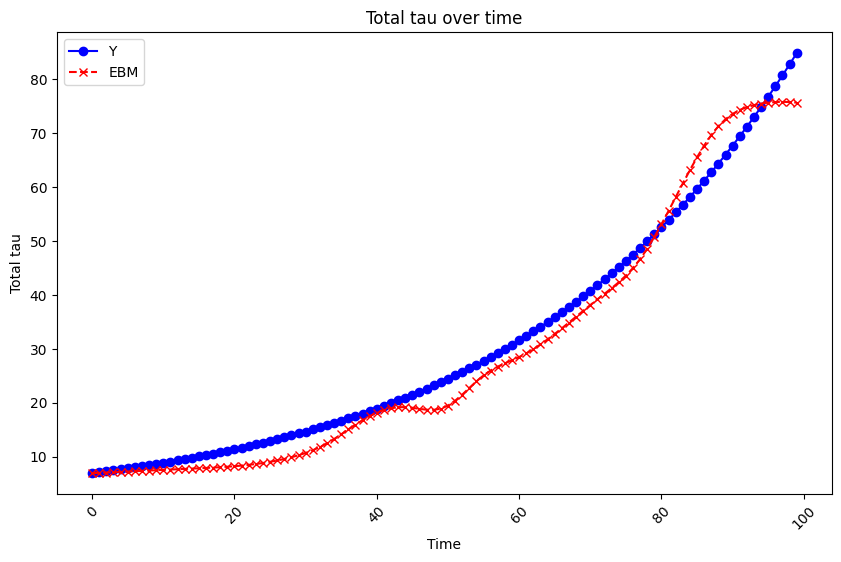

In [12]:
# Plot total tau over time to compare the scales of EBM and Y
plt = total_tau_plot(Y, EBM_data_excluded, 'Y', 'EBM')
plt.show

In [25]:
# Save Y to .csv
Nexis = pandas.DataFrame(Y)
Nexis.to_csv('Fitted_Nexis_1_subtype.csv')